In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy

In [2]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


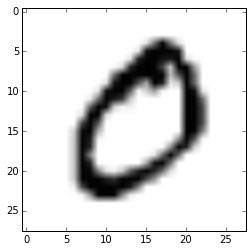

In [3]:
data_array = mnist.data
plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

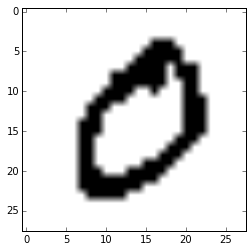

In [4]:
#Convert image to binary matrix
for img in data_array:
    img[img < 100] = 0
    img[img > 0] = 1

plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

In [5]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, num_epochs, learning_rate=0.1):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
    
    def _sigmoid(self,x):
        return 1.0/(1.0+np.exp(-x))
    
    def _gen_prob(self,a,b):
        return self._sigmoid(np.dot(a,b))
    
    def _gen_assoc(self,a):
        probs = self._gen_prob(a,self.weights)
        return np.dot(a.T,probs)
    
    def _sample_v_given_h(self, h):  # h does not contain bias
        probs = self._gen_prob(self.weights, np.insert(h,0,1))
        sample = probs > np.random.rand(self.num_visible + 1)
        return sample[1:]
    
    def _sample_h_given_v(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1, axis = 1).T)
        sample = probs > np.random.rand(self.num_hidden + 1, self.num_data)
        return sample[1:].T
    
    def _sample_h_given_v_nontrain(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1).T)
        sample = probs > np.random.rand(self.num_hidden + 1)
        return sample[1:]

    def CDk(self):
        max_epochs = self.num_epochs + 1
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        for epoch in xrange(0, max_epochs):
            up_probs = self._gen_prob(self.data,self.weights)
            up_associations = self._gen_assoc(self.data)
            up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
            
            down_probs = self._gen_prob(up_states,self.weights.T)
            down_probs[:,0] = 1 
            down_associations = self._gen_assoc(down_probs)
            
            self.weights += self.learning_rate * \
                ((up_associations - down_associations)/self.num_data)
                
            error = np.sum((self.data - down_probs) ** 2)
            print("Epoch: ", epoch, ", Error: ", error)
            if epoch == self.num_epochs:
                return down_probs
   

In [6]:
class DBN(object):
    '''
    Deep Belief Network
    
    'layer_nodes' describes the network architechture 
    i.e. [3,4,5,3] is a DBN with 3 visible units (not including bias), 
        4 unit hidden layer, 5 unit hidden layer, 3 unit hidden layer
    '''

    def __init__(self, data, layer_nodes, num_epochs, learning_rate=0.1):
        self.data = data
        self.num_data = data.shape[0]
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.layer_nodes = layer_nodes
        self.num_layers = len(self.layer_nodes)
        self.RBM_layer = range(0,len(self.layer_nodes)-1)  # list of stacked RBMs
        self.RBM_layer_messages = range(0,len(self.layer_nodes))  # list of messages 
        self.RBM_layer_messages[0] = self.data
        
    def _build(self):
        for i in xrange(0,len(self.layer_nodes)-1):
            self.RBM_layer[i] = RBM(self.RBM_layer_messages[i], self.layer_nodes[i], self.layer_nodes[i+1], self.num_epochs, self.learning_rate)
            down_probs = self.RBM_layer[i].CDk()  # train
            
            self.RBM_layer_messages[i+1] = self.RBM_layer[i]._sample_h_given_v(self.RBM_layer_messages[i])
            
            error = np.sum((self.RBM_layer_messages[i] - down_probs[:,1:]) ** 2)
            print("DBN Layer: ", i, ", DBN Error: ", error)
        return
    
    def _dbn_sample_v_given_h(self, h):  # h does not contain bias
        temp = h
        for i in xrange(len(self.layer_nodes)-2,-1,-1):
            temp = self.RBM_layer[i]._sample_v_given_h(temp)
        return temp
    
    def _dbn_sample_h_given_v(self, v):  # v does not contain bias
        temp = v
        for i in xrange(0,len(self.layer_nodes)-1):
            temp = self.RBM_layer[i]._sample_h_given_v_nontrain(temp)
        return temp

        


In [52]:
'''
Andre's DBN tests
'''
visible_units = data_array.shape[1]
num_epochs = 1000
learning_rate = 0.4

dbn_learner = DBN(data_array, [visible_units,50,20], num_epochs, learning_rate)
dbn_learner._build()

Epoch:  0 , Error:  47051392.9898
Epoch:  1 , Error:  45349749.9782
Epoch:  2 , Error:  6865073.65322
Epoch:  3 , Error:  10560049.4275
Epoch:  4 , Error:  8632426.33703
Epoch:  5 , Error:  7007209.63241
Epoch:  6 , Error:  6401469.21319
Epoch:  7 , Error:  6230705.4065
Epoch:  8 , Error:  5927284.77788
Epoch:  9 , Error:  5924826.29625
Epoch:  10 , Error:  5695973.63087
Epoch:  11 , Error:  5705692.96535
Epoch:  12 , Error:  5513825.25068
Epoch:  13 , Error:  5493938.85773
Epoch:  14 , Error:  5351522.64358
Epoch:  15 , Error:  5278007.34841
Epoch:  16 , Error:  5182067.9244
Epoch:  17 , Error:  5066887.76994
Epoch:  18 , Error:  5010641.3495
Epoch:  19 , Error:  4873029.27613
Epoch:  20 , Error:  4847181.12616
Epoch:  21 , Error:  4705081.47434
Epoch:  22 , Error:  4693676.74487
Epoch:  23 , Error:  4555227.88611
Epoch:  24 , Error:  4550062.35825
Epoch:  25 , Error:  4426277.50224
Epoch:  26 , Error:  4418986.13587
Epoch:  27 , Error:  4315741.00479
Epoch:  28 , Error:  4300787.8459

In [53]:
print(dbn_learner.RBM_layer[0].weights.shape)
print(data_array[11].shape)

(785, 51)
(784,)


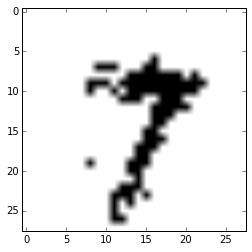

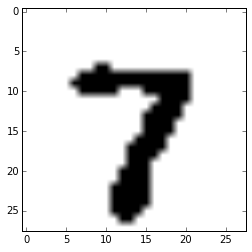

In [210]:
img = 44444

h = dbn_learner._dbn_sample_h_given_v(data_array[img])
v = dbn_learner._dbn_sample_v_given_h(h)

plt.imshow(v.reshape(28,28), cmap = 'Greys')
plt.show()

plt.imshow(data_array[img].reshape(28,28), cmap = 'Greys')
plt.show()

In [154]:
'''
Vincent's old RBM tests
'''

visible_units = data_array.shape[1]
epochs = 100
hidden_layers = 50
learning_rate = 0.4

r = RBM(data_array, visible_units, hidden_layers, epochs, learning_rate)
sample = r.CDk()

Epoch:  0 , Error:  47051392.9903
Epoch:  1 , Error:  45211103.5609
Epoch:  2 , Error:  6780073.84362
Epoch:  3 , Error:  11032760.3835
Epoch:  4 , Error:  9680449.88479
Epoch:  5 , Error:  7730288.15195
Epoch:  6 , Error:  6778437.00564
Epoch:  7 , Error:  6163621.32749
Epoch:  8 , Error:  6128918.39686
Epoch:  9 , Error:  5820261.36833
Epoch:  10 , Error:  5809841.33918
Epoch:  11 , Error:  5590761.33879
Epoch:  12 , Error:  5540502.89319
Epoch:  13 , Error:  5377457.931
Epoch:  14 , Error:  5309275.89461
Epoch:  15 , Error:  5180346.9861
Epoch:  16 , Error:  5097191.92852
Epoch:  17 , Error:  5001833.38896
Epoch:  18 , Error:  4902492.27596
Epoch:  19 , Error:  4837232.32982
Epoch:  20 , Error:  4720016.65414
Epoch:  21 , Error:  4674950.3209
Epoch:  22 , Error:  4555731.18859
Epoch:  23 , Error:  4522319.40386
Epoch:  24 , Error:  4404730.17699
Epoch:  25 , Error:  4380153.63134
Epoch:  26 , Error:  4272934.06101
Epoch:  27 , Error:  4251314.1301
Epoch:  28 , Error:  4157781.50383


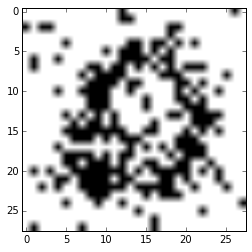

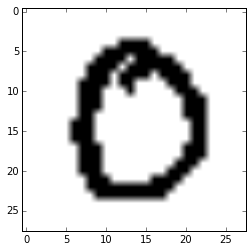

In [185]:
plt.imshow(sample[11][1:].reshape(28,28) > np.random.rand(28,28), cmap = 'Greys')
plt.show()
#print(sample[11][1:].reshape(28,28))
plt.imshow(data_array[11].reshape(28,28), cmap = 'Greys')
plt.show()